# Course Project
Author: Olga Chernytska
 
## Part 3. Demonstration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.externals import joblib

Input: direction 0/1, point [lat,lon] on the route, time - randomly generated

Output: dataframe with columns 'stop #' and 'time to arrival'. Data frame contains next 5 stops that bus is going to pass moving to end point stop.

#### Step 1. Define helper functions

- Input generation and preprocessing

In [2]:
def dist_fast(point1, point2):
    dist = (point1[0]-point2[0])**2 + (point1[1]-point2[1])**2
    return dist


def add_route_points(df_route_points, direction):
    df = df_route_points.copy()
    df = df[df['direction']==direction]
    df = df.reset_index(drop = True)
    
    max_counter = len(df)
    i = 0
    while (i < max_counter):
        dist = dist_fast([df.at[i,'lat'], df.at[i,'lon']], [df.at[i+1,'lat'], df.at[i+1,'lon']])
        
        if np.sqrt(dist)*100000 > 30:
            new_lat = (df.at[i,'lat'] + df.at[i+1,'lat'])/2
            new_lon = (df.at[i,'lon'] + df.at[i+1,'lon'])/2
            new = pd.DataFrame({'lat': new_lat, 'lon': new_lon, 'direction': direction}, index=[0])
            df = pd.concat([df.iloc[:(i+1)], new, df.iloc[(i+1):]])
            df = df.reset_index(drop = True)
            max_counter = len(df) - 1
        else:
            i += 1
            
    return df

In [3]:
def input_generator(df):
    direction = np.random.randint(low=0,high=2)
    random_index = np.random.choice(df_route_points[df_route_points['direction']==direction].index)
    route_point = [df_route_points.at[random_index,'lat'], 
                 df_route_points.at[random_index,'lon']]
    time = np.random.choice(df['start_time'])
    return time, direction, route_point

In [4]:
def add_features(df):
    df['season'] = np.where(df['start_time'].dt.month.isin([12,1,2]), 'winter',
                             np.where(df['start_time'].dt.month.isin([3,4,5]), 'spring',
                             np.where(df['start_time'].dt.month.isin([6,7,8]), 'summer', 'autumn')))
    df['weekday'] = df['start_time'].dt.weekday_name
    df['hour'] = df['start_time'].dt.hour
    df['minute'] = (round(df['start_time'].dt.minute/15,0)*15 % 60).astype(int)
    df['route_interval'] = df['start_stop'].str.extract('(#\d*)', expand = False) + '_' \
                        + df['end_stop'].str.extract('(#\d*)', expand = False)
    return df

In [5]:
def closest_stop(df_route_points, df_route_stops, direction):
    df = df_route_points.copy()
    df = df[df['direction']== direction]
    df['closest_stop'] = 'none'
    df = df.reset_index(drop=True)
    
    direction_stops = df_route_stops[df_route_stops['direction']==direction]
    direction_stops = direction_stops.reset_index(drop=True)
    
    num_stop = 0
    prev_dist = 50000
    
    num_points = len(df)
    n_stops = len(direction_stops)

    for i in range(num_points):
        
        if num_stop != n_stops - 1:
        
            this_dist = dist_fast([direction_stops.at[num_stop, 'lat'], direction_stops.at[num_stop, 'lon']],
                             [df.at[i, 'lat'], df.at[i, 'lon']])
        
            if this_dist >= prev_dist:
                df.at[i-1,'closest_stop'] = 'stop #' + str(num_stop).zfill(2) + \
                        ': id=' + str(direction_stops.at[num_stop, 'stop_id'])
                    
                prev_dist = 50000
                num_stop += 1
                                  
            else:
                prev_dist = this_dist
            
        else:
            df.at[num_points-1,'closest_stop'] = 'stop #' + str(num_stop).zfill(2) + \
                    ': id=' + str(direction_stops.at[num_stop, 'stop_id'])
                
        
    return df

In [6]:
def max_stop_distance(route_direction):
    df = route_direction.copy()
    df = df[df['closest_stop'] != 'none']
    df = df.reset_index(drop = True)
    
    max_dist = -1
    for i in range(len(df)-1):
        point1 = [df.at[i,'lat'], df.at[i,'lon']]
        point2 = [df.at[i+1,'lat'], df.at[i+1,'lon']]
        this_dist = dist_fast(point1, point2)
        if this_dist > max_dist:
            max_dist = this_dist
            
    return max_dist

In [7]:
def find_route_location(route_point, direction):
    if direction == 0:
        df = route_direction0
        max_dist = max_dist_direction0
    else:
        df = route_direction1
        max_dist = max_dist_direction1
        
    prev_dist = 5000
    counter = 0
    
    #find closest index
    index = len(df)-1
    for i in range(len(df)):
        this_dist = dist_fast([df.at[i, 'lat'], df.at[i, 'lon']], route_point)
        
        #print(str(i) + ' ' + str(this_dist) + ' ' + str(this_dist < prev_dist) + ' '  + str(counter))
        
        if this_dist > prev_dist and this_dist < max_dist*1.05:
            
            if counter == 50 or i==len(df)-1:
                index = i-counter-1
                #print(index)
                break
            else:
                counter += 1
            
        else:
            prev_dist = this_dist
            counter = 0
            
    #find previous stop
    prev_stop = ''
    for i in range(index, -1, -1):
        this_point = df.at[i, 'closest_stop']
        if this_point == 'none':
            continue
        else:
            prev_stop = this_point
            break
      
    
    #find next stop
    next_stop = ''
    for i in range(index, len(df)):
        this_point = df.at[i, 'closest_stop']
        if this_point == 'none':
            continue
        else:
            next_stop = this_point
            break
            
    return prev_stop, next_stop

In [8]:
def get_stop_coordinates(stop_name):
    stop_id = int(stop_name[(stop_name.find('=')+1):])
    df = df_route_stops[df_route_stops['stop_id'] == stop_id]
    lat = df[['lat']].iloc[0,0]
    lon = df[['lon']].iloc[0,0]
    return [lat, lon]
    
def interval_passed(route_point, prev_stop, next_stop):
    
    if prev_stop == next_stop:
        return 1
    
    
    prev_stop_coord = get_stop_coordinates(prev_stop)
    next_stop_coord = get_stop_coordinates(next_stop)
    
    dist_to_prev = np.sqrt(dist_fast(route_point, prev_stop_coord))
    dist_to_next = np.sqrt(dist_fast(route_point, next_stop_coord))
    
    passed = dist_to_prev/(dist_to_prev + dist_to_next)
    return passed

In [9]:
def find_next_stops(next_stop, direction):
    if direction == 0:
        df = route_direction0
    else:
        df = route_direction1
    
    df = df[df['closest_stop'] != 'none']
    df = df.reset_index(drop = True)
    index = df[df['closest_stop'] == next_stop].index[0]
    df = df[index:]
    df = df.iloc[:5]
    
    return np.array(df['closest_stop'])

- Predictions

In [10]:
def prepare_data_for_prediting(time, direction, prev_stop, next_stop, true_columns):
    
    df = pd.DataFrame({'start_time': time, 'direction': direction, 
                      'start_stop': prev_stop, 'end_stop': next_stop}, index = [0])
    df = add_features(df)
    
    dummies_direction = pd.get_dummies(df['direction'], prefix = 'is_direction')
    dummies_route_stops = pd.get_dummies(df['route_interval'],  prefix = 'is_stops')

    dummies_season = pd.get_dummies(df['season'], prefix='is')
    dummies_weekday = pd.get_dummies(df['weekday'],  prefix = 'is')
    dummies_hour = pd.get_dummies(df['hour'], prefix = 'is_hour')
    dummies_minute = pd.get_dummies(df['minute'], prefix = 'is_minute')
    
    df_new = dummies_direction.join([dummies_route_stops, dummies_season, dummies_weekday, 
                                   dummies_hour, dummies_minute] )
       
    missing_columns = set(true_columns) - set(df_new.columns)    
    for c in missing_columns:
        df_new[c] = 0
    
    df_new = df_new[true_columns]
    
    return df_new

In [11]:
def predict_next_5(model, true_columns, time, direction, prev_stop, next_stop, passed, next_stops):
    
    predictions = []
    
    if prev_stop == next_stop:
        time_to_stop = 0
    else:
        new_obs = prepare_data_for_prediting(time, direction, prev_stop, next_stop, true_columns)
        time_to_stop = model.predict(new_obs)[0]
        time_to_stop = time_to_stop * (1-passed)
        arrival_time = time + pd.Timedelta(seconds = time_to_stop)
        predictions.append([time, next_stop, time_to_stop, arrival_time])
    
    n_pred = len(next_stops) - 1
    
    if n_pred > 0:
        for i in range(1, len(next_stops)):
            prev_stop = next_stops[i-1]
            next_stop = next_stops[i]
            time += pd.Timedelta(seconds = time_to_stop)
            new_obs = prepare_data_for_prediting(time, direction, prev_stop, next_stop, true_columns)
            time_to_stop = model.predict(new_obs)[0]
            arrival_time = time + pd.Timedelta(seconds = time_to_stop)
            predictions.append([time, next_stop, time_to_stop, arrival_time])
    
    predictions = pd.DataFrame(predictions, columns = ['prev_stop_departure_time',
                                                       'next_stop', 'time_between_stops', 'arrival_time'])
    predictions['seconds_to_arrival'] = np.cumsum(predictions['time_between_stops'])
    
    
    return predictions[['next_stop', 'seconds_to_arrival', 'arrival_time']]

#### Step 2. Load model and datasets needed.

In [12]:
def load_data(direction):
    df = pd.read_csv('output/direction'+str(direction) + '_df_clean.csv')
    df = df[['drive_index','start_stop','end_stop','start_time','time_diff_seconds']]
    df['start_time'] = pd.to_datetime(df['start_time'], unit='ns')
    df['direction'] = direction
    
    return df

direction0_df = load_data(0)
direction1_df = load_data(1)

df_all = pd.concat([direction0_df, direction1_df])
df_all = df_all.reset_index(drop = True)

In [13]:
df_route_points = pd.read_csv('./input/routeid1723724_route.csv')
df_route_points = df_route_points.drop_duplicates()
df_route_points['direction'] = 1 - df_route_points['dir']
df_route_points = df_route_points[['lat','lon','direction']]
df_route_points = df_route_points.reset_index(drop = True)

df_route_stops = pd.read_csv('./input/routeid1723724_stops.csv')
df_route_stops = df_route_stops[['lat','lon','stop_id','direction']]

df_route_points = pd.concat([add_route_points(df_route_points, 0), add_route_points(df_route_points, 1)])
df_route_points = df_route_points.reset_index(drop = True)

route_direction0 = closest_stop(df_route_points, df_route_stops, 0)
route_direction1 = closest_stop(df_route_points, df_route_stops, 1)

max_dist_direction0 = max_stop_distance(route_direction0)
max_dist_direction1 = max_stop_distance(route_direction1)

In [14]:
true_columns = ['is_direction_1', 'is_stops_#01_#02', 'is_stops_#02_#03',
       'is_stops_#03_#04', 'is_stops_#04_#05', 'is_stops_#05_#06',
       'is_stops_#06_#07', 'is_stops_#07_#08', 'is_stops_#08_#09',
       'is_stops_#09_#10', 'is_stops_#10_#11', 'is_stops_#11_#12',
       'is_stops_#12_#13', 'is_stops_#13_#14', 'is_stops_#14_#15',
       'is_stops_#15_#16', 'is_stops_#16_#17', 'is_stops_#17_#18',
       'is_stops_#18_#19', 'is_stops_#19_#20', 'is_stops_#20_#21',
       'is_stops_#21_#22', 'is_stops_#22_#23', 'is_stops_#23_#24',
       'is_stops_#24_#25', 'is_stops_#25_#26', 'is_stops_#26_#27',
       'is_stops_#27_#28', 'is_spring', 'is_summer', 'is_winter', 'is_Monday',
       'is_Saturday', 'is_Sunday', 'is_Thursday', 'is_Tuesday', 'is_Wednesday',
       'is_hour_3', 'is_hour_4', 'is_hour_5', 'is_hour_6', 'is_hour_7',
       'is_hour_8', 'is_hour_9', 'is_hour_10', 'is_hour_11', 'is_hour_12',
       'is_hour_13', 'is_hour_14', 'is_hour_15', 'is_hour_16', 'is_hour_17',
       'is_hour_18', 'is_hour_19', 'is_minute_15', 'is_minute_30',
       'is_minute_45']

In [15]:
#load model
model = joblib.load('model.pkl')

#### Step 3. Demonstration

Time: 2017-09-26T04:36:37.060401750
Direction: 1
Bus Location: [49.82356652125, 24.03342645875]


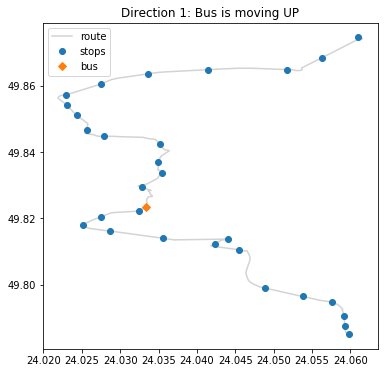


Bus is departed from stop #13: id=39164 and passed share=0.23 of the interval to stop #14: id=36559.

Next closest stops on the route: ['stop #14: id=36559' 'stop #15: id=36589' 'stop #16: id=36631'
 'stop #17: id=36685' 'stop #18: id=36711']


,next_stop,seconds_to_arrival,arrival_time
0,stop #14: id=36559,155.847378,2017-09-26 04:39:12.907779750
1,stop #15: id=36589,298.304957,2017-09-26 04:41:35.365358750
2,stop #16: id=36631,433.488589,2017-09-26 04:43:50.548990750
3,stop #17: id=36685,628.974608,2017-09-26 04:47:06.035010750
4,stop #18: id=36711,795.359942,2017-09-26 04:49:52.420344750


In [22]:
time, direction, route_point = input_generator(df_all)
prev_stop, next_stop = find_route_location(route_point, direction)
passed = interval_passed(route_point, prev_stop, next_stop)
next_stops = find_next_stops(next_stop, direction)

print('Time: ' + str(time))
print('Direction: ' + str(direction))
print('Bus Location: ' + str(route_point))

stops = df_route_stops[df_route_stops['direction']==direction]
route = df_route_points[df_route_points['direction']==direction]

if direction ==0 :
    title = 'Direction ' + str (direction) + ': Bus is moving DOWN'
else:
    title = 'Direction ' + str (direction) + ': Bus is moving UP'

plt.figure(figsize = [6,6])
plt.plot(route['lon'], route['lat'], color = '#D3D3D3',label = 'route')
plt.plot(stops['lon'], stops['lat'], 'o', label = 'stops')
plt.plot(route_point[1], route_point[0], 'D', label = 'bus')
plt.legend()
plt.title(title)
plt.show()

print('\nBus is departed from ' + str(prev_stop) + ' and passed share=' +  
        str(np.round(passed,2)) + ' of the interval to ' + str(next_stop) + '.')
print('\nNext closest stops on the route: ' + str(next_stops))

predictions = predict_next_5(model, true_columns, time, direction, prev_stop, next_stop, passed, next_stops)
predictions